## Drilling parameters analysis and drilling rate prediction
### Introduction

In this research, I seek to develop a machine learning model for predicting drilling speed based on various drilling parameters. The initial dataset contains the following parameters:

_Measured Depth_

_Weight on Bit_

_Pump Pressure_

_Torque_

_Rate of Penetration_

_Bit Speed_

_Flow Rate_

_Drilling Mud Weight_

_Bit Diameter_

_Buoyant Weight_

_True Vertical Depth_

_Gamma Ray_

**Goal of Research:**

The goal of this research is to create and optimise a model that predicts the drilling rate as accurately as possible based on the parameters provided. This is done as part of the development of a system for optimising the drilling process by means of recommendation systems.


## I. Data exploration

### Import libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from scipy.stats import linregress
import math
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN
from scipy.stats import spearmanr

### Import data

Deleting the 'Unnamed: 0' column. Output 5 first and last rows of the dataframe.

In [26]:
drilling_data = pd.read_csv ('USROP_A 0 N-NA_F-9_Ad.csv')
del drilling_data['Unnamed: 0']
drilling_data.head(-5)

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
0,491.033,5.842270,9440.922214,0.244047,42.864024,84.00,2784.321942,1.210000,311.15,93.780222,490.760309,150.88
1,491.185,6.241431,9499.941336,0.244047,42.315384,84.00,2784.321942,1.210000,311.15,93.979803,490.910880,150.88
2,491.222,6.241431,9499.941336,0.244047,42.315384,84.00,2784.321942,1.210000,311.15,93.979803,490.910880,150.88
3,491.338,6.368437,9313.024466,0.216931,42.894504,84.00,2784.321942,1.210000,311.15,94.079593,491.061756,146.26
4,491.341,6.368437,9313.024466,0.216931,42.894504,84.00,2784.321942,1.210000,311.15,94.079593,491.061756,146.26
...,...,...,...,...,...,...,...,...,...,...,...,...
13736,1205.536,12.605332,10988.795226,9.422935,40.337232,194.54,1927.456082,1.198264,215.90,88.137533,1012.937878,25.37
13737,1205.591,12.605332,10988.795226,9.422935,40.337232,194.54,1927.456082,1.198264,215.90,88.137533,1012.937878,25.37
13738,1205.636,12.455646,10986.726799,9.666982,40.614600,194.68,1927.456082,1.198264,215.90,88.119390,1013.016516,25.37
13739,1205.646,12.455646,10986.726799,9.666982,40.614600,194.68,1927.456082,1.198264,215.90,88.119390,1013.021393,25.37


### Data research and feature engineering

Conversion of input parameters to the metric system of units. Renaming of parameters for convenience of work with them.

In [27]:
drilling_data['wob_ts'] = drilling_data['Weight on Bit kkgf'] / 9.80665
drilling_data['whp_bar'] = drilling_data['Average Standpipe Pressure kPa'] / 100
drilling_data['flow_lps'] = drilling_data['Mud Flow In L/min'] / 60
drilling_data['hookload_ts'] = drilling_data['Average Hookload kkgf'] / 9.80665

drilling_data = drilling_data.rename(columns={'Measured Depth m': 'md_m', 
                        'Average Surface Torque kN.m': 'torque_kn.m',
                        'Rate of Penetration m/h': 'rop_mph',
                        'Average Rotary Speed rpm': 'rpm',
                        'Mud Density In g/cm3': 'mw',
                        'Diameter mm': 'db_mm',
                        'Hole Depth (TVD) m': 'tvd_m',
                        'USROP Gamma gAPI': 'gr_api'
                        })
work_edition = ['md_m', 'tvd_m',  'wob_ts', 'hookload_ts', 'whp_bar','rpm', 'torque_kn.m', 'rop_mph','flow_lps', 'mw', 'db_mm', 'gr_api']
drilling_data = drilling_data[work_edition]
drilling_data.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api
0,491.033,490.760309,0.595746,9.562921,94.409222,84.00,0.244047,42.864024,46.405366,1.210000,311.15,150.88
1,491.185,490.910880,0.636449,9.583273,94.999413,84.00,0.244047,42.315384,46.405366,1.210000,311.15,150.88
2,491.222,490.910880,0.636449,9.583273,94.999413,84.00,0.244047,42.315384,46.405366,1.210000,311.15,150.88
3,491.338,491.061756,0.649400,9.593449,93.130245,84.00,0.216931,42.894504,46.405366,1.210000,311.15,146.26
4,491.341,491.061756,0.649400,9.593449,93.130245,84.00,0.216931,42.894504,46.405366,1.210000,311.15,146.26
...,...,...,...,...,...,...,...,...,...,...,...,...
13736,1205.536,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.90,25.37
13737,1205.591,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.90,25.37
13738,1205.636,1013.016516,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.90,25.37
13739,1205.646,1013.021393,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.90,25.37


Check for missing values in the dataset

In [28]:
total = drilling_data.isnull().sum().sort_values(ascending=False)
percent_1 = drilling_data.isnull().sum()/drilling_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(12)

,Total,%
md_m,0,0.0
tvd_m,0,0.0
wob_ts,0,0.0
hookload_ts,0,0.0
whp_bar,0,0.0
rpm,0,0.0
torque_kn.m,0,0.0
rop_mph,0,0.0
flow_lps,0,0.0
mw,0,0.0


Show drilling parameters with depth reference.

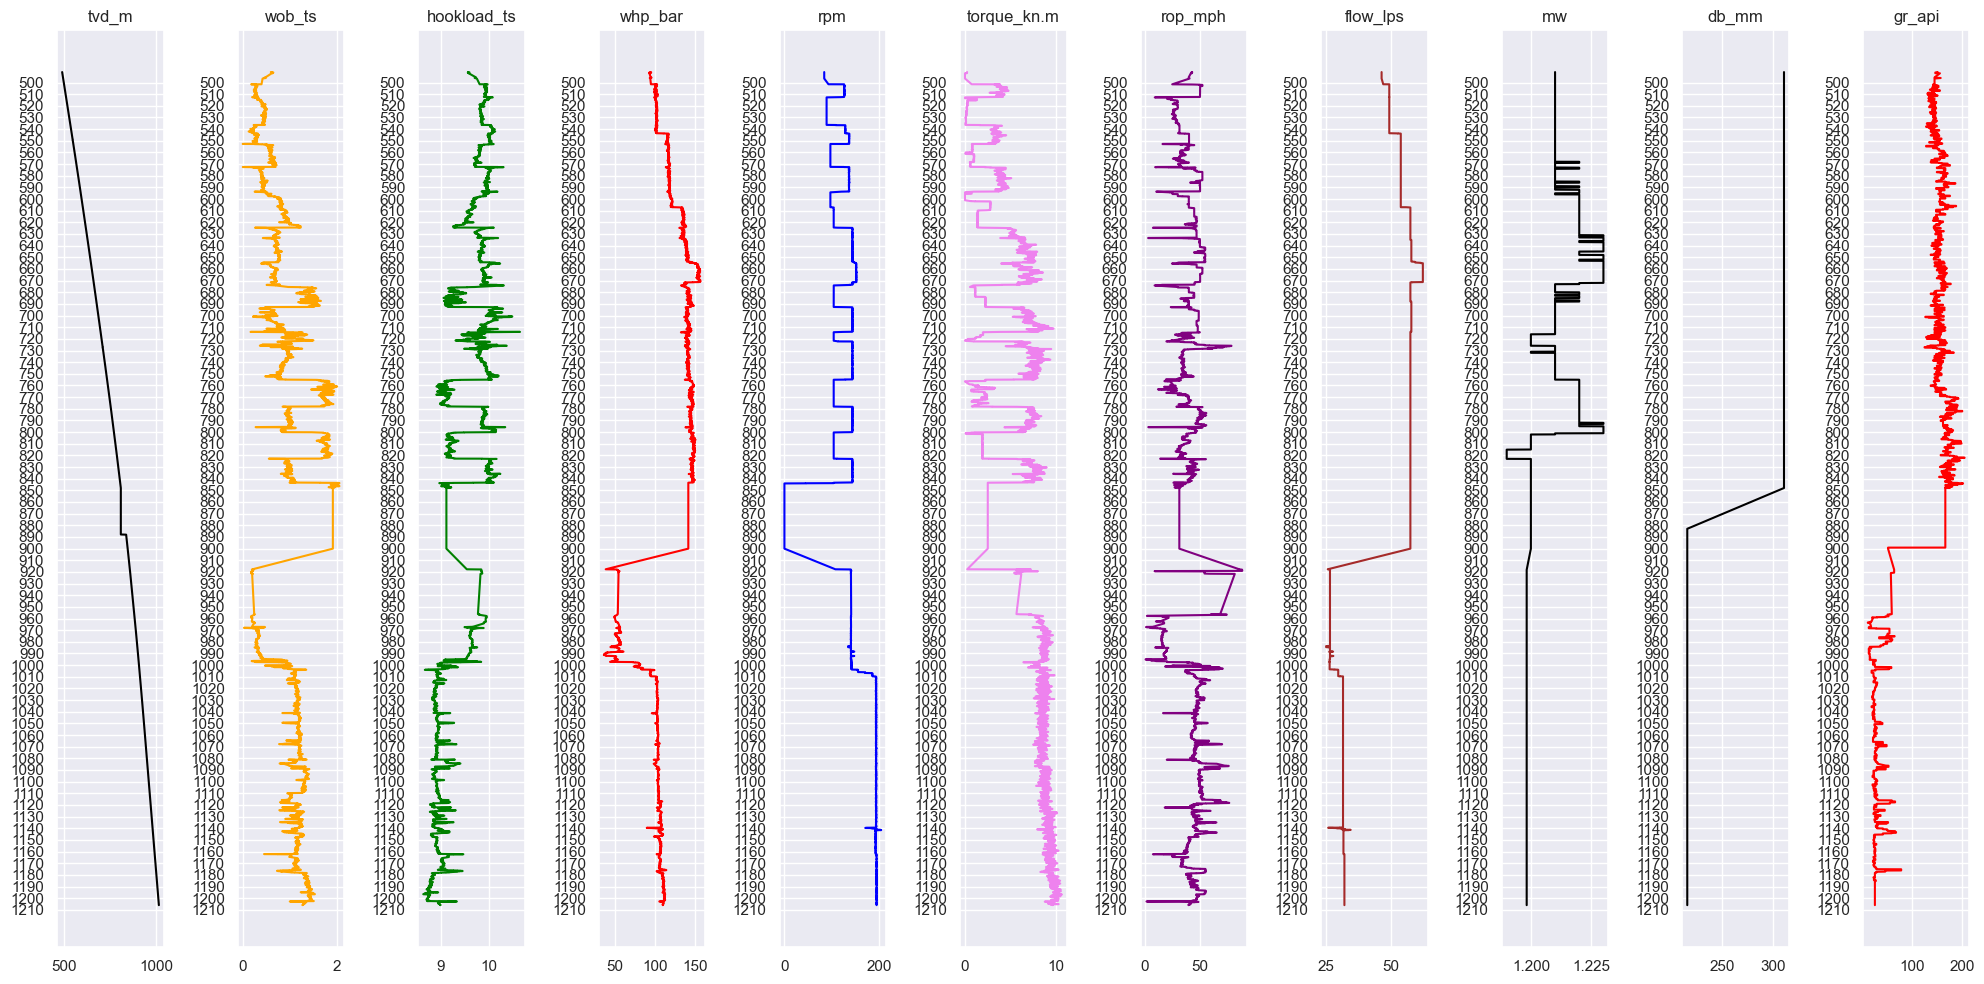

In [29]:
logs = drilling_data.columns[1:]
colors = ['black', 'orange', 'green', 'red', 'blue', 'violet', 'purple', 'brown', 'black', 'black', 'red']

plt.figure(figsize=(20, 10))
for i in range(len(logs)):
  plt.subplot(1, 11, i+1)
  plt.plot(drilling_data[logs[i]], drilling_data.md_m, color=colors[i])
  plt.title(logs[i])
  plt.gca().invert_yaxis()

  y_ticks = np.arange(500, drilling_data.md_m.max() + 10, 10)
  plt.yticks(y_ticks)

plt.tight_layout()

Investigate for anomalies in the dataset

In [30]:
drilling_data.describe()

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api
count,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000
mean,844.154778,781.324298,0.947193,9.453512,115.620645,143.319564,5.936502,39.101351,45.235099,1.206574,269.962309,103.790758
std,216.074764,157.351243,0.453736,0.447945,27.797058,41.557296,3.282083,11.969047,12.959926,0.010030,47.189656,64.629420
min,491.033000,490.760309,0.000463,8.639700,35.927201,0.000000,0.013558,0.548640,25.108638,1.190000,215.900000,11.270000
25%,653.008500,644.361830,0.582332,8.970413,102.668624,104.000000,2.509619,31.796736,31.591787,1.198264,215.900000,26.310000
50%,808.029500,776.789810,0.965867,9.588361,114.989728,143.190000,7.389208,40.716708,53.771147,1.200000,311.150000,144.720000
75%,1043.332250,929.222424,1.209530,9.872358,141.329011,193.000000,8.677235,47.512224,57.453722,1.210000,311.150000,158.570000
max,1205.999000,1013.142703,2.049819,10.636004,156.644059,204.170000,10.616055,88.440768,62.242899,1.230000,311.150000,204.761000


As can be seen from the diagrams, the data is represented by two drilling intervals

In [31]:
mean_dd = drilling_data.groupby('db_mm')
mean_dd.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api
0,491.033,490.760309,0.595746,9.562921,94.409222,84.00,0.244047,42.864024,46.405366,1.210000,311.15,150.88
1,491.185,490.910880,0.636449,9.583273,94.999413,84.00,0.244047,42.315384,46.405366,1.210000,311.15,150.88
2,491.222,490.910880,0.636449,9.583273,94.999413,84.00,0.244047,42.315384,46.405366,1.210000,311.15,150.88
3,491.338,491.061756,0.649400,9.593449,93.130245,84.00,0.216931,42.894504,46.405366,1.210000,311.15,146.26
4,491.341,491.061756,0.649400,9.593449,93.130245,84.00,0.216931,42.894504,46.405366,1.210000,311.15,146.26
...,...,...,...,...,...,...,...,...,...,...,...,...
13736,1205.536,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.90,25.37
13737,1205.591,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.90,25.37
13738,1205.636,1013.016516,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.90,25.37
13739,1205.646,1013.021393,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.90,25.37


View the average values of the dataset drilling parameters, grouping the data by bit diameter (excluding TVD and MD)

In [32]:
mean_dd = drilling_data.groupby('db_mm').aggregate({'wob_ts': 'mean', 'hookload_ts': 'mean', 'whp_bar': 'mean','rpm': 'mean', 'torque_kn.m': 'mean', 'rop_mph': 'mean','flow_lps': 'mean', 'mw': 'mean', 'gr_api': 'mean'})
mean_dd.head()

,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,gr_api
db_mm,,,,,,,,,
215.90,1.009030,9.098218,93.332272,173.650971,8.649469,38.513559,31.187127,1.198319,33.347004
311.15,0.900082,9.724196,132.601174,120.211401,3.869613,39.549164,55.937631,1.212863,157.458750


Therefore drilling data is presented for two intervals:
491.033m - 883.006m with bit diameter 311.15mm
883.006m - 1205.7m with bit diameter 215.9mm. 

Let's separate them into separate sets and add features:
- drilling specific energy (DSE)
- depth of cut (DOC)

In [33]:
drilling_data_311mm = drilling_data.loc[drilling_data['md_m'] < 840, :]
drilling_data_311mm['dse'] = 0.35 * (((4 * drilling_data_311mm.wob_ts)/(math.pi * pow(drilling_data_311mm.db_mm,2)))
                                      + (480 * 1 * (drilling_data_311mm.rpm + drilling_data_311mm.flow_lps) 
                                         * (2000 * drilling_data_311mm['torque_kn.m'])) / (pow(drilling_data_311mm.db_mm,2)
                                                                                            * drilling_data_311mm.rop_mph))
drilling_data_311mm['doc'] = 16.67 * drilling_data_311mm.rop_mph / drilling_data_311mm.rpm
drilling_data_311mm.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api,dse,doc
0,491.033,490.760309,0.595746,9.562921,94.409222,84.000,0.244047,42.864024,46.405366,1.21,311.15,150.880,2.576775,8.506468
1,491.185,490.910880,0.636449,9.583273,94.999413,84.000,0.244047,42.315384,46.405366,1.21,311.15,150.880,2.610185,8.397589
2,491.222,490.910880,0.636449,9.583273,94.999413,84.000,0.244047,42.315384,46.405366,1.21,311.15,150.880,2.610185,8.397589
3,491.338,491.061756,0.649400,9.593449,93.130245,84.000,0.216931,42.894504,46.405366,1.21,311.15,146.260,2.288840,8.512516
4,491.341,491.061756,0.649400,9.593449,93.130245,84.000,0.216931,42.894504,46.405366,1.21,311.15,146.260,2.288840,8.512516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7597,839.425,801.122909,1.011658,10.019583,147.175007,143.622,8.060338,41.100756,57.454037,1.20,311.15,181.667,136.855869,4.770506
7598,839.541,801.210996,1.011658,10.019583,147.175007,143.622,8.060338,41.100756,57.454037,1.20,311.15,181.667,136.855869,4.770506
7599,839.572,801.234161,1.032287,10.010471,148.026578,143.741,8.260999,41.100756,57.454037,1.20,311.15,181.667,140.345888,4.766557
7600,839.596,801.252754,1.032287,10.010471,148.026578,143.741,8.260999,41.100756,57.454037,1.20,311.15,181.667,140.345888,4.766557


As the data in the interval 833-960m are unconditioned, we exclude them from the set for the interval 215 mm

In [34]:
drilling_data_215mm = drilling_data.loc[drilling_data['md_m'] > 960, :]
drilling_data_215mm['dse'] = 0.35 * (((4 * drilling_data_215mm.wob_ts)/(math.pi * pow(drilling_data_215mm.db_mm,2)))
                                      + (480 * 1 * (drilling_data_215mm.rpm + drilling_data_215mm.flow_lps) 
                                         * (2000 * drilling_data_215mm['torque_kn.m'])) / (pow(drilling_data_215mm.db_mm,2)
                                                                                            * drilling_data_215mm.rop_mph))
drilling_data_215mm['doc'] = 16.67 * drilling_data_215mm.rop_mph / drilling_data_215mm.rpm

drilling_data_215mm.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api,dse,doc
8091,962.254,883.991628,0.192415,9.925549,50.717835,140.43,8.677235,14.194536,26.585579,1.198264,215.9,18.79,735.954780,1.684988
8092,962.257,883.991628,0.192415,9.925549,50.717835,140.43,8.677235,14.194536,26.585579,1.198264,215.9,18.79,735.954780,1.684988
8093,962.284,883.991628,0.192415,9.925549,50.717835,140.43,8.677235,14.194536,26.585579,1.198264,215.9,18.79,735.954780,1.684988
8094,962.302,883.991628,0.192415,9.925549,50.717835,140.43,8.677235,14.194536,26.585579,1.198264,215.9,18.79,735.954780,1.684988
8095,962.406,884.081849,0.203053,9.932487,50.659919,140.48,8.229815,9.936480,26.585579,1.198264,215.9,17.85,997.420941,1.179108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,1205.536,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.9,25.37,381.678028,3.456470
13737,1205.591,1012.937878,1.285386,8.987527,109.887952,194.54,9.422935,40.337232,32.124268,1.198264,215.9,25.37,381.678028,3.456470
13738,1205.636,1013.016516,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.9,25.37,389.129322,3.477735
13739,1205.646,1013.021393,1.270122,8.985677,109.867268,194.68,9.666982,40.614600,32.124268,1.198264,215.9,25.37,389.129322,3.477735


ROP, DSE and DOC are key indicators of drilling efficiency, so consider the function of drilling rate as a function of the energy required to drill through a unit volume of rock.

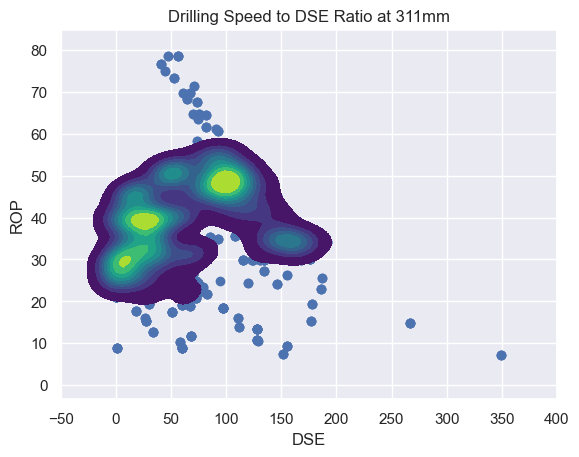

In [35]:
plt.scatter(drilling_data_311mm.dse, drilling_data_311mm.rop_mph)
sns.kdeplot(x=drilling_data_311mm.dse, y=drilling_data_311mm.rop_mph, fill=True, cmap='viridis')
# sns.regplot(x=drilling_data_311mm.dse, y=drilling_data_311mm.rop_mph, scatter_kws={'alpha':0.5}, line_kws={"color":"black"}, ci=95)
plt.title('Drilling Speed to DSE Ratio at 311mm')
plt.xlabel('DSE')
plt.xlim(-50, 400)
plt.ylabel('ROP')
plt.show()

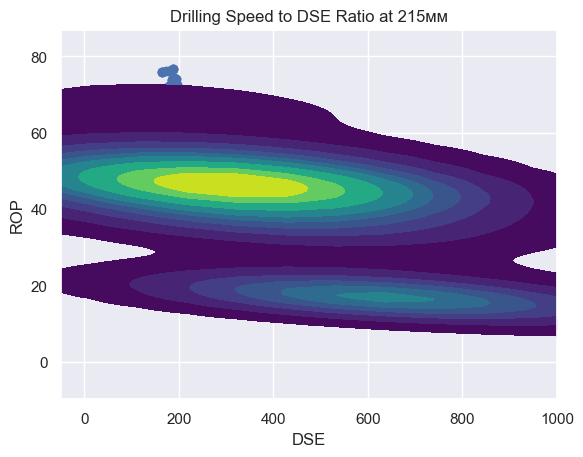

In [36]:
plt.scatter(drilling_data_215mm.dse, drilling_data_215mm.rop_mph)
sns.kdeplot(x=drilling_data_215mm.dse, y=drilling_data_215mm.rop_mph, fill=True, cmap='viridis')
plt.title('Drilling Speed to DSE Ratio at 215мм')
plt.xlabel('DSE')
plt.xlim(-50, 1000)
plt.ylabel('ROP')
plt.show()

Let's normalise the data by drilling intervals

In [37]:
scaler_311 = MinMaxScaler()
normalized_data = scaler_311.fit_transform(drilling_data_311mm)
normalized_drilling_data_311mm = pd.DataFrame(normalized_data, columns=drilling_data_311mm.columns)
normalized_drilling_data_311mm.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api,dse,doc
0,0.000000,0.000000,0.297572,0.379347,0.029378,0.000000,0.023743,0.527844,0.000000,0.50,0.0,0.327001,0.002413,0.927531
1,0.000436,0.000484,0.317919,0.391118,0.038582,0.000000,0.023743,0.520596,0.000000,0.50,0.0,0.327001,0.002446,0.915168
2,0.000542,0.000484,0.317919,0.391118,0.038582,0.000000,0.023743,0.520596,0.000000,0.50,0.0,0.327001,0.002446,0.915168
3,0.000874,0.000970,0.324393,0.397004,0.009431,0.000000,0.020950,0.528246,0.000000,0.50,0.0,0.269295,0.002127,0.928218
4,0.000883,0.000970,0.324393,0.397004,0.009431,0.000000,0.020950,0.528246,0.000000,0.50,0.0,0.269295,0.002127,0.928218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7597,0.998384,0.998621,0.505480,0.643472,0.852319,0.876794,0.828911,0.504550,0.697626,0.25,0.0,0.711545,0.135789,0.503324
7598,0.998716,0.998905,0.505480,0.643472,0.852319,0.876794,0.828911,0.504550,0.697626,0.25,0.0,0.711545,0.135789,0.503324
7599,0.998805,0.998979,0.515792,0.638202,0.865601,0.878544,0.849581,0.504550,0.697626,0.25,0.0,0.711545,0.139256,0.502876
7600,0.998874,0.999039,0.515792,0.638202,0.865601,0.878544,0.849581,0.504550,0.697626,0.25,0.0,0.711545,0.139256,0.502876


In [38]:
scaler_215 = MinMaxScaler()
normalized_data = scaler_215.fit_transform(drilling_data_215mm)
normalized_drilling_data_215mm = pd.DataFrame(normalized_data, columns=drilling_data_215mm.columns)
normalized_drilling_data_215mm.head(-5)

,md_m,tvd_m,wob_ts,hookload_ts,whp_bar,rpm,torque_kn.m,rop_mph,flow_lps,mw,db_mm,gr_api,dse,doc
0,0.000000,0.000000,0.110222,0.994633,0.189809,0.087342,0.538710,0.179446,0.156914,0.0,0.0,0.112727,0.032210,0.195987
1,0.000012,0.000000,0.110222,0.994633,0.189809,0.087342,0.538710,0.179446,0.156914,0.0,0.0,0.112727,0.032210,0.195987
2,0.000123,0.000000,0.110222,0.994633,0.189809,0.087342,0.538710,0.179446,0.156914,0.0,0.0,0.112727,0.032210,0.195987
3,0.000197,0.000000,0.110222,0.994633,0.189809,0.087342,0.538710,0.179446,0.156914,0.0,0.0,0.112727,0.032210,0.195987
4,0.000624,0.000699,0.117303,1.000000,0.189066,0.088058,0.432258,0.123452,0.156914,0.0,0.0,0.098636,0.045959,0.134798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,0.998100,0.998414,0.837746,0.269052,0.949141,0.862113,0.716129,0.523227,0.745358,0.0,0.0,0.211363,0.013580,0.410257
5646,0.998326,0.998414,0.837746,0.269052,0.949141,0.862113,0.716129,0.523227,0.745358,0.0,0.0,0.211363,0.013580,0.410257
5647,0.998511,0.999023,0.827586,0.267621,0.948876,0.864118,0.774194,0.526875,0.745358,0.0,0.0,0.211363,0.013972,0.412829
5648,0.998552,0.999061,0.827586,0.267621,0.948876,0.864118,0.774194,0.526875,0.745358,0.0,0.0,0.211363,0.013972,0.412829


Let's consider lithotype selection for each drilling interval

At the 311mm drilling interval with the length of 840m, 4 lithotypes are identified by means of clustering.
At the 215mm drilling interval with the length of 244m, 2 lithotypes are identified by means of clustering.
It should be noted that for more correct lithotype identification along the borehole section it is necessary to clarify geological and geophysical data.

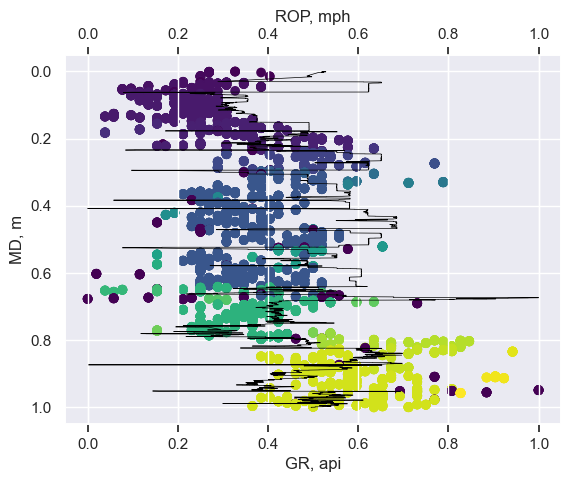

In [39]:
X = normalized_drilling_data_311mm.loc[:, ['gr_api', 'md_m', 'rop_mph']].values
dbscan = DBSCAN(eps=0.05, min_samples=10)
clusters = dbscan.fit_predict(X)

fig, ax1 = plt.subplots()

sc = ax1.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
ax1.set_xlabel('GR, api')
ax1.set_ylabel('MD, m')
ax1.invert_yaxis()

ax2 = ax1.twiny()
ax2.plot(X[:, 2], X[:, 1], color='black', linewidth=0.5)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('ROP, mph')

plt.show()

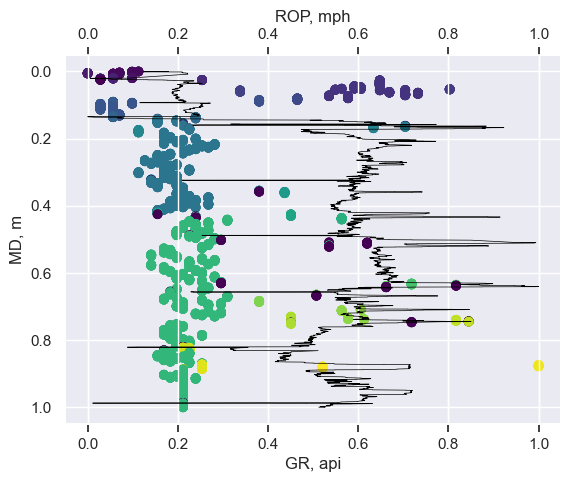

In [40]:
X = normalized_drilling_data_215mm.loc[:, ['gr_api', 'md_m', 'rop_mph']].values
dbscan = DBSCAN(eps=0.05, min_samples=10)
clusters = dbscan.fit_predict(X)

fig, ax1 = plt.subplots()

sc = ax1.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
ax1.set_xlabel('GR, api')
ax1.set_ylabel('MD, m')
ax1.invert_yaxis()

ax2 = ax1.twiny()
ax2.plot(X[:, 2], X[:, 1], color='black', linewidth=0.5)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('ROP, mph')

plt.show()

### Analysis of mutual correlations between drilling parameters

We perform a pairwise chart analysis that uses a "small set" approach to visualise the univariate distribution of all variables in the dataset together with all their pairwise relationships.

Depth-related kernel density maps show a complex distribution of clusters for each control parameter. This is typical of several rock types and the parameters used to drill them. In the future, logs and rock properties should be added to give the model more lithological context.

<Figure size 2000x2000 with 0 Axes>

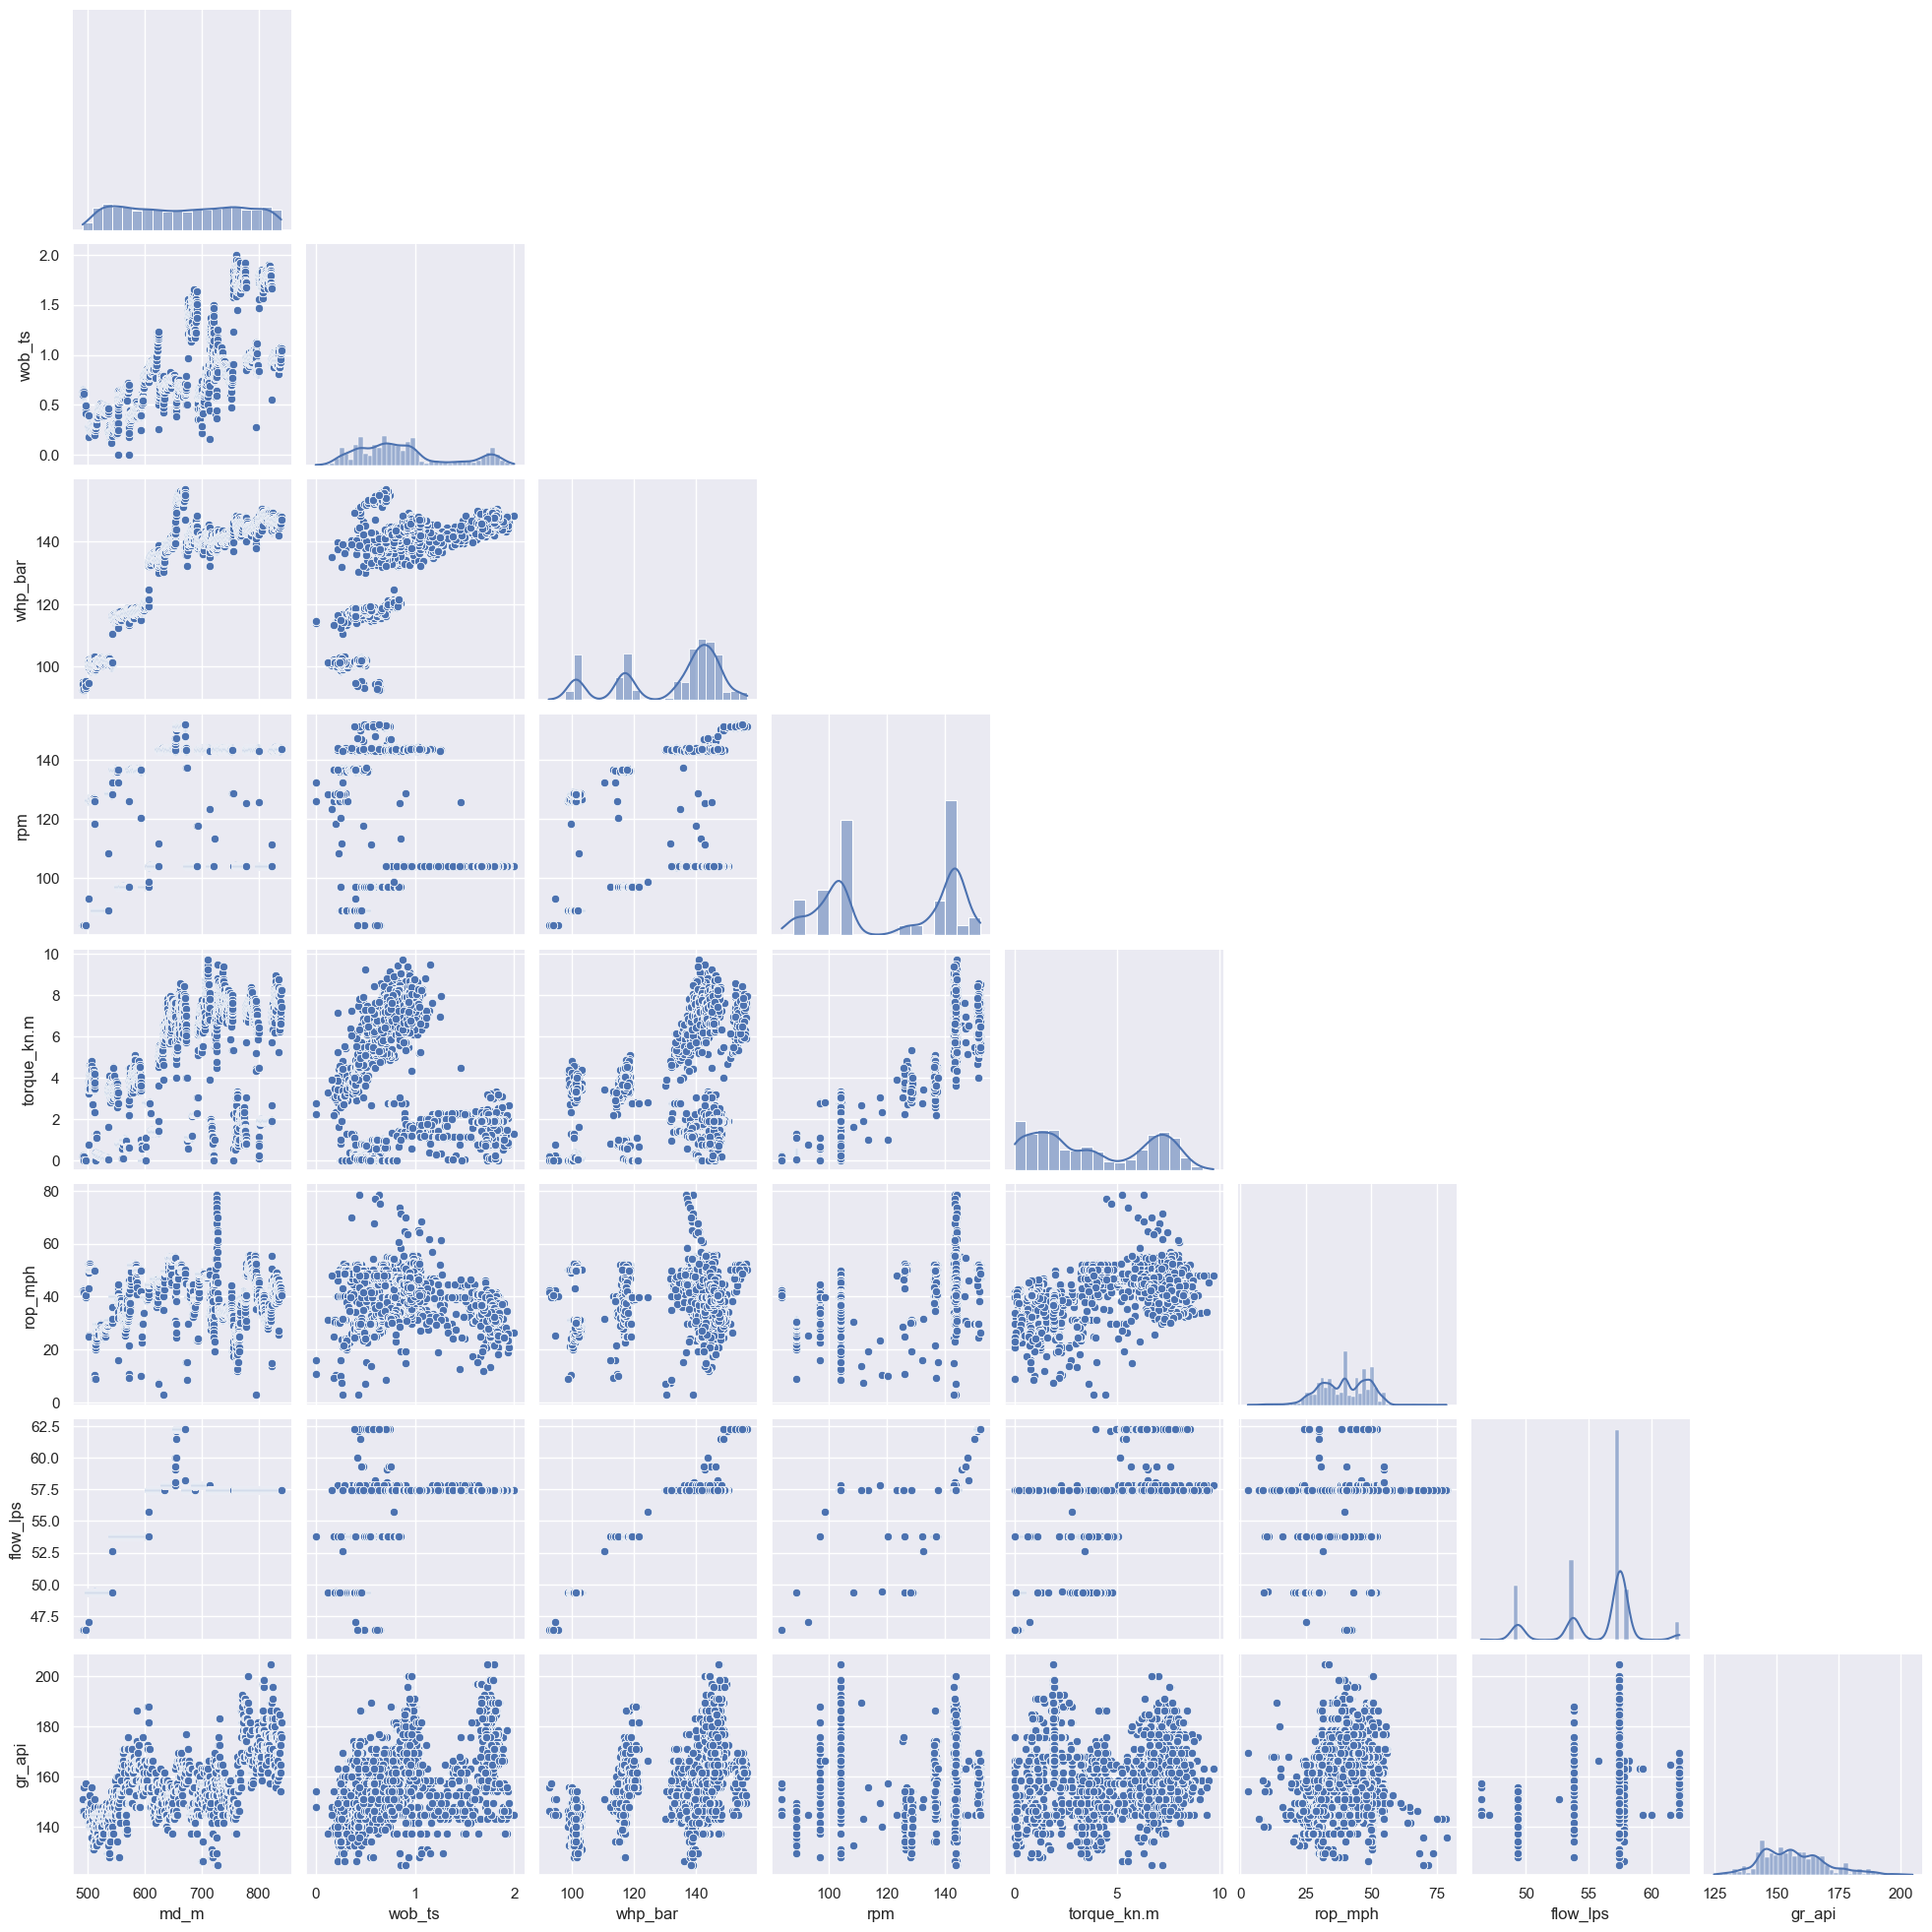

In [41]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(drilling_data_311mm[['md_m', 'wob_ts', 'whp_bar', 'rpm', 'torque_kn.m', 'rop_mph', 'flow_lps', 'gr_api']], 
             corner=True,
             diag_kws={'kde': True, 'fill': True})
plt.show()

<Figure size 2000x2000 with 0 Axes>

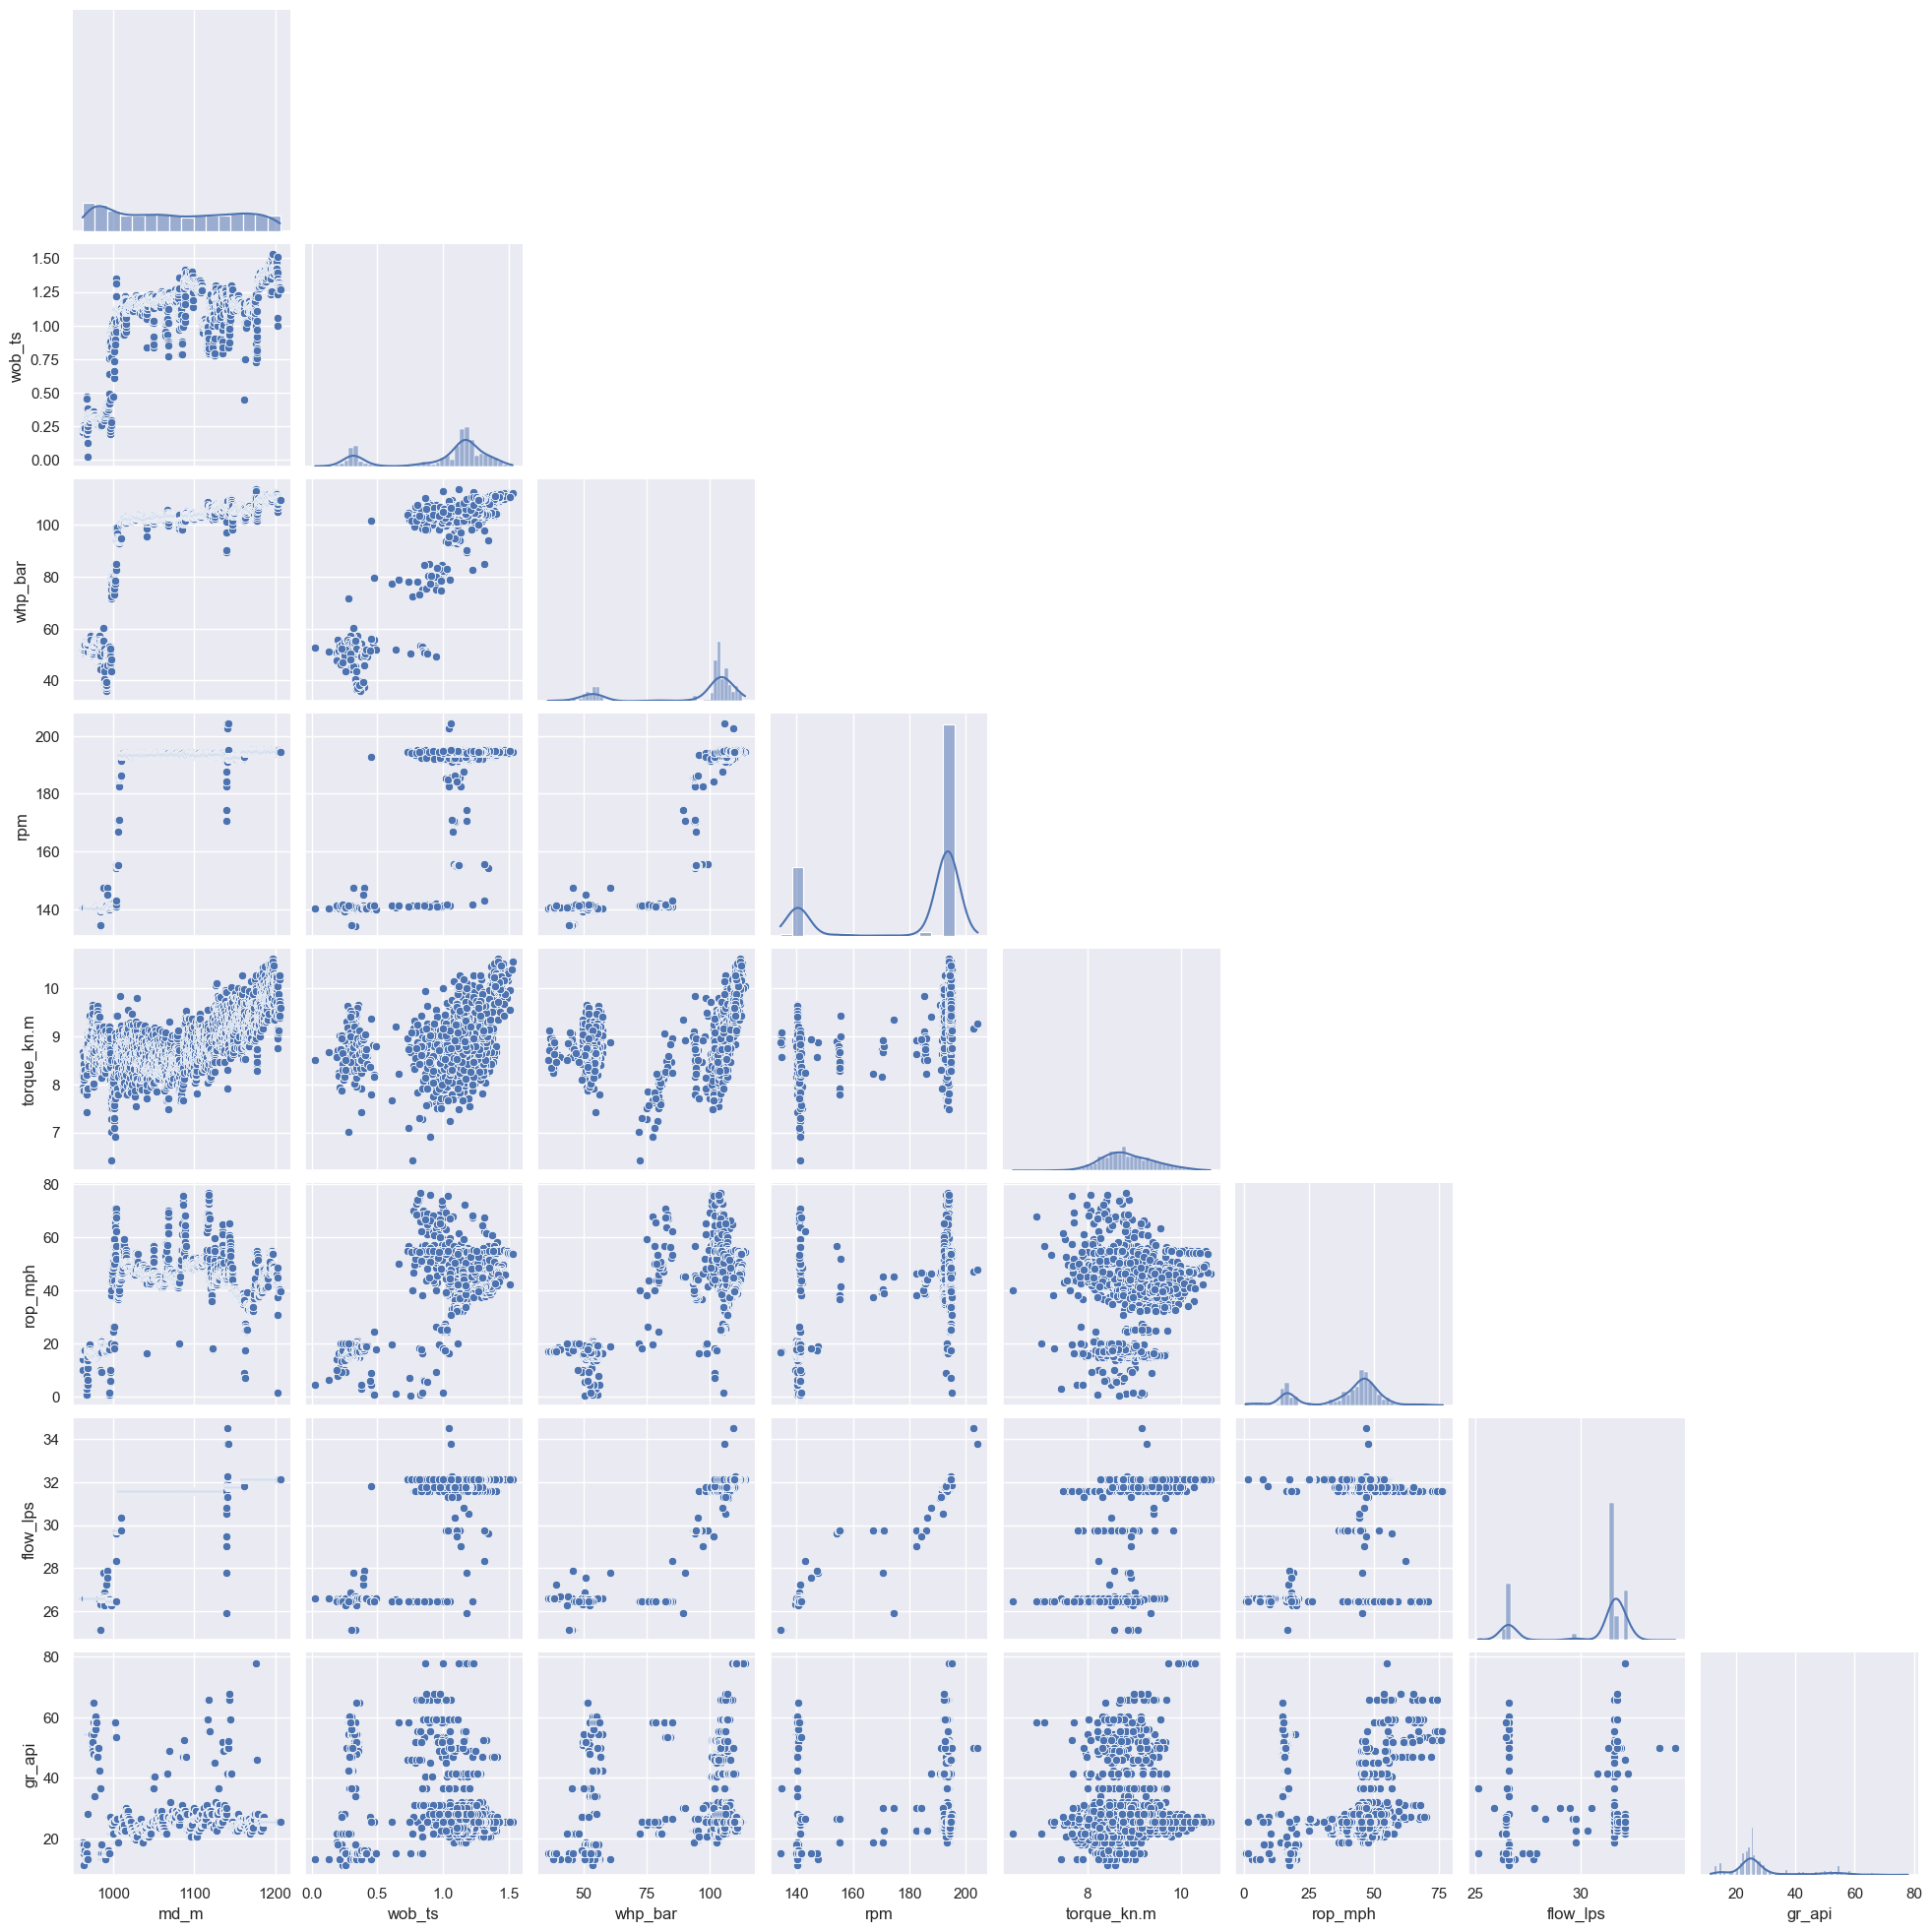

In [42]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(drilling_data_215mm[['md_m', 'wob_ts', 'whp_bar', 'rpm', 'torque_kn.m', 'rop_mph', 'flow_lps', 'gr_api']], 
             corner=True,
             diag_kws={'kde': True, 'fill': True})
plt.show()

Spearman's correlation matrix is used to analyse the relationships (estimation of linear relationships) between traits, as all our data have clear deviations from the normal distribution. 

This is done to determine whether there is a linear relationship between two variables. Multicollinearity in the context of regression analysis occurs when two or more independent variables in a regression model are highly correlated with each other.

Excluding the natural correlation of all features with measured and vertical depth, we see strong correlations between the parameters: 
 - flushing fluid flow rate and weight on hook, surface pressure, GC;
 - gamma logging and hook weight, surface pressure, 

obvious intercorrelations such as, for example, ROP and torque are excluded from the description.

ROP is correlated with drilling parameters:
 - ROP_mph / WHP_bar = 0.42 
 - ROP_mph / RPM = 0.38

In this case we can see the correlation with geomechanics, when we calculate the borehole wall stability, we can conclude that the smaller bit diameters require less radial stress (and consequently the drilling fluid density) to compensate for the rock pressure on the borehole walls. And also that clayey rocks are more prone to collapse and require higher pressure in the borehole.

                 md_m     tvd_m    wob_ts  hookload_ts   whp_bar       rpm  \
md_m         1.000000  1.000000  0.520282    -0.756594 -0.286489  0.762012   
tvd_m        1.000000  1.000000  0.520282    -0.756594 -0.286489  0.762013   
wob_ts       0.520282  0.520282  1.000000    -0.718605  0.381785  0.260193   
hookload_ts -0.756594 -0.756594 -0.718605     1.000000  0.274485 -0.470238   
whp_bar     -0.286489 -0.286489  0.381785     0.274485  1.000000 -0.202862   
rpm          0.762012  0.762013  0.260193    -0.470238 -0.202862  1.000000   
torque_kn.m  0.835085  0.835085  0.132402    -0.498422 -0.412184  0.840220   
rop_mph      0.139011  0.139011  0.181038    -0.123751  0.165006  0.498654   
flow_lps    -0.548635 -0.548635  0.125457     0.506741  0.894821 -0.354439   
mw          -0.796846 -0.796846 -0.227541     0.623276  0.598350 -0.516049   
db_mm       -0.858078 -0.858077 -0.200260     0.712385  0.678632 -0.637008   
gr_api      -0.613027 -0.613027 -0.013732     0.579297  0.762034

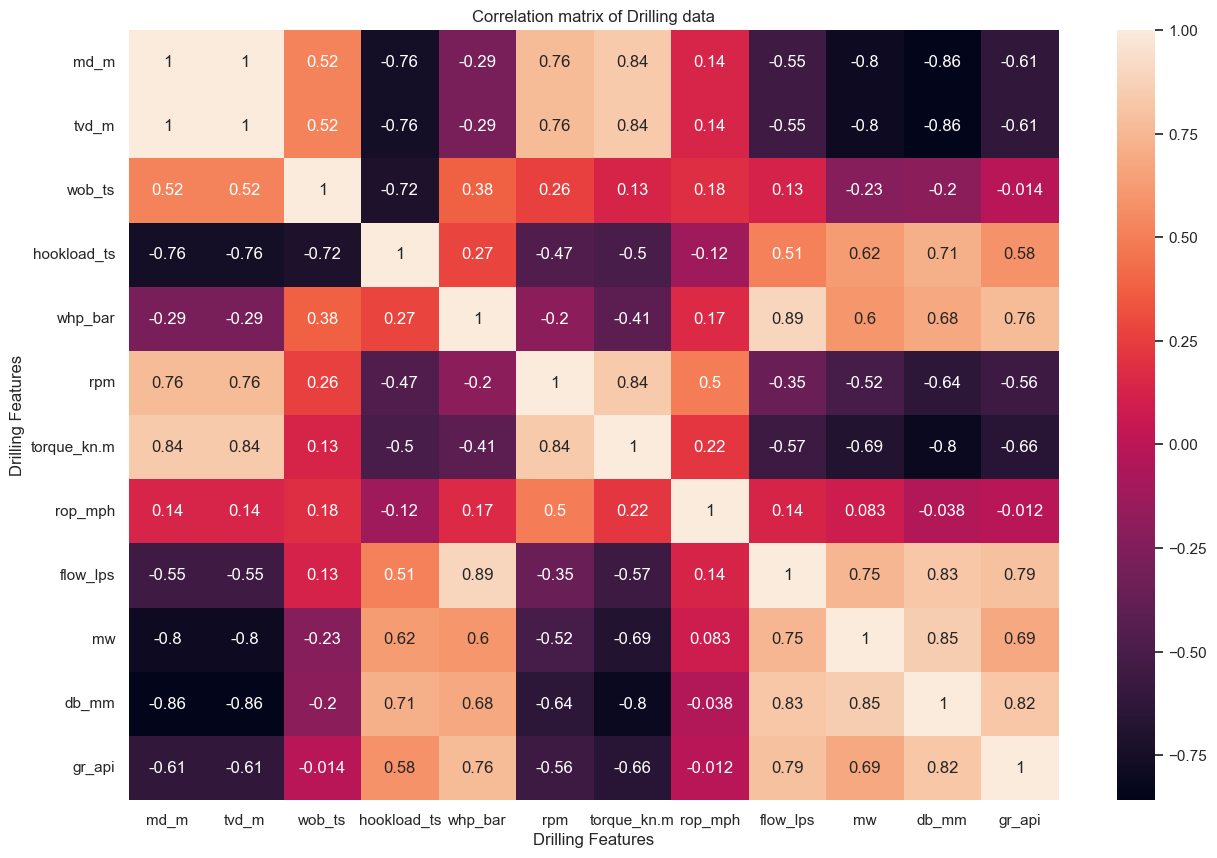

In [43]:
correlation_matrix = drilling_data.corr(method='spearman')
print(correlation_matrix)

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot = True)
plt.title("Correlation matrix of Drilling data")
plt.xlabel("Drilling Features")
plt.ylabel("Drilling Features")
plt.show()

### Modelling

We train and test the model on the 311mm dataset. We divide the training and test sets in the ratio 3:1.

In [44]:
X = normalized_drilling_data_311mm[['md_m', 'torque_kn.m', 'doc']] 
y = normalized_drilling_data_311mm['rop_mph'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

After the experiments, the highest metric is achieved by the Random Forest model.

Mean square error (MSE) for the 311mm interval: 3.410251016429636e-06
Coefficient of determination (R^2) for the 311mm interval: 0.9997690575968537
Coefficient of determination (R^2) for the 215mm interval: 0.6322366397741417


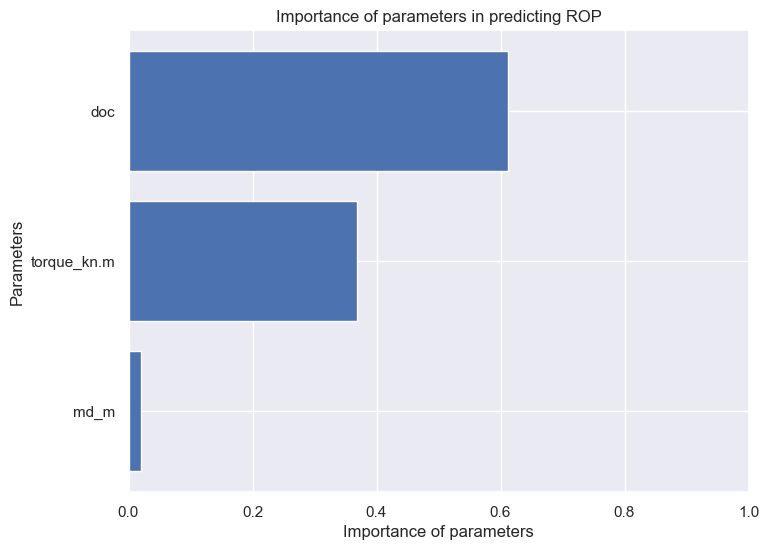

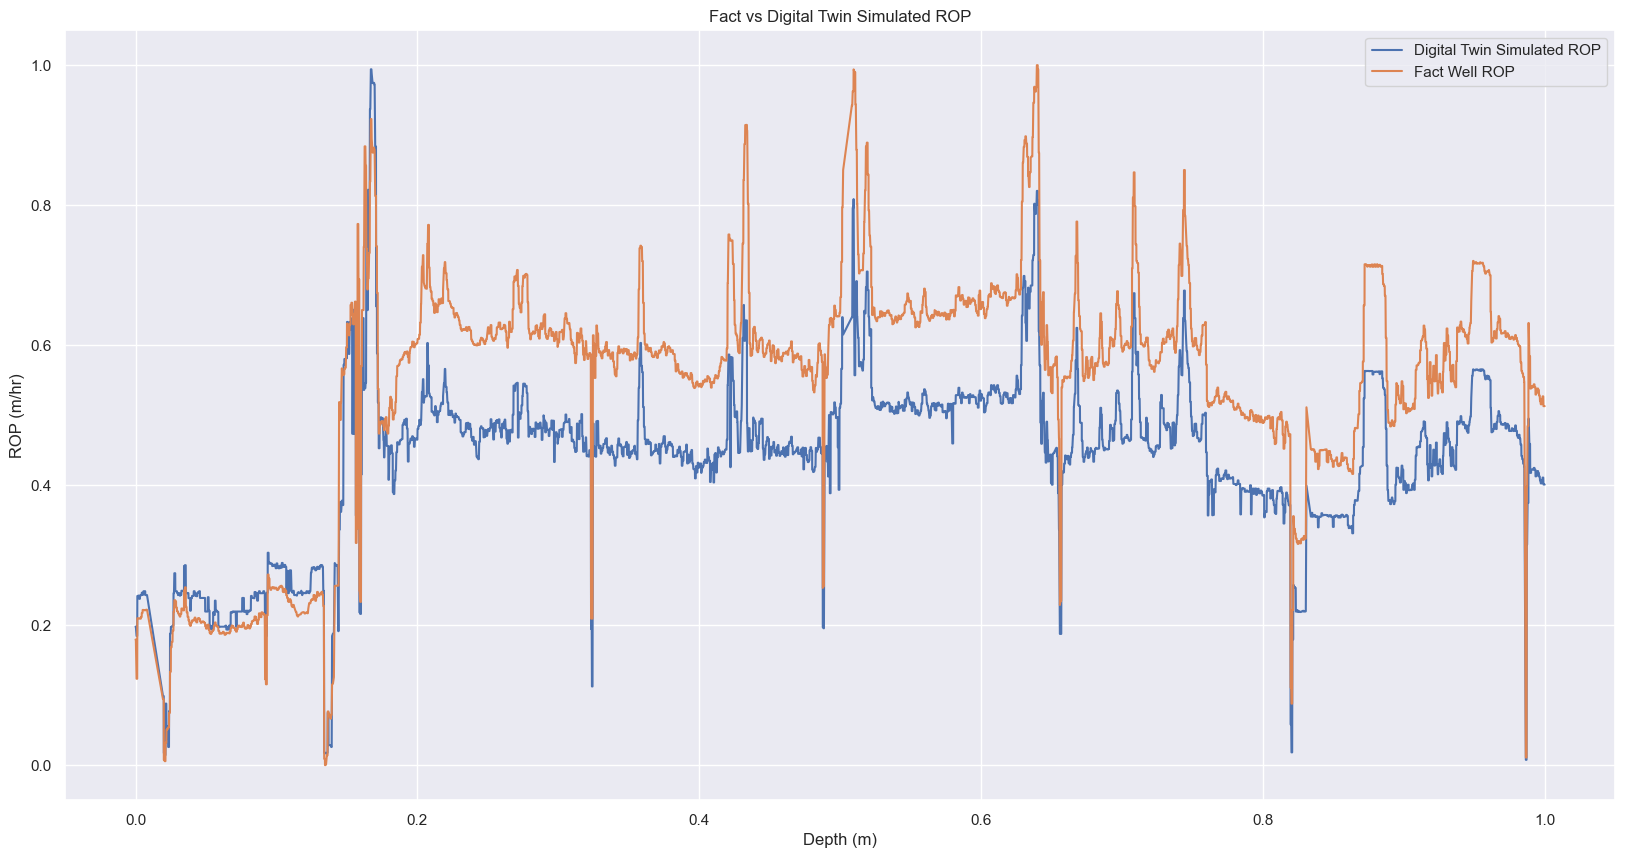

In [45]:
model_forest = RandomForestRegressor(n_estimators=100, random_state=42)
model_forest.fit(X_train, y_train)

y_pred = model_forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean square error (MSE) for the 311mm interval:", mse)
print("Coefficient of determination (R^2) for the 311mm interval:", r2)

feature_importance = model_forest.feature_importances_
features = X.columns

new_data = normalized_drilling_data_215mm[['md_m', 'torque_kn.m', 'doc']]
y_new_data = normalized_drilling_data_215mm['rop_mph']  
predicted_rop = model_forest.predict(new_data)

mse2_215mm = mean_squared_error(y_new_data, predicted_rop)
r2_215mm = r2_score(y_new_data, predicted_rop)
print("Coefficient of determination (R^2) for the 215mm interval:", r2_215mm)

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance)
plt.xlim(0, 1)
plt.xlabel('Importance of parameters')
plt.ylabel('Parameters')
plt.title('Importance of parameters in predicting ROP')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(normalized_drilling_data_215mm['md_m'], predicted_rop, label='Digital Twin Simulated ROP')
plt.plot(normalized_drilling_data_215mm['md_m'], normalized_drilling_data_215mm['rop_mph'], label='Fact Well ROP')
plt.xlabel('Depth (m)')
plt.ylabel('ROP (m/hr)')
plt.title('Fact vs Digital Twin Simulated ROP')
plt.legend()

### Conclusions

- The application of cross-validation increases the accuracy of the model;
- The developed model predicts the drilling speed quite accurately on the basis of bit diameter and drilling mechanics parameters;
- The graph of the importance of the parameters in predicting the mechanical drilling speed (depth of cut per bit rotation and torque) suggests that the introduction of functions based on rheological and geomechanical rock parameters will improve the quality of the model;
- the addition of data on the diameter and characteristics of rock-destroying tools can improve the quality of the model;
- increasing the petrophysical and mechanical functions of rock properties and linking mud hydraulics and clay chemistry can improve the quality of the model;
- Other steps could also be taken:
    - Apply pipeline to improve the model;
    - Exploring other ways of extracting lithotypes and applying ensembles of machine learning methods;
    - increasing the amount of data to be studied;
    - developing back-prediction algorithms and modelling recommender systems (neurostyles, graph models).